In [1]:
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import sklearn as sl
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 350)

# Import Data

In [2]:
path=r"C:\Users\Akash Choudhary\Desktop\GitClone 3\Data_Analyst_Unguided_Projects_Portfolio\Funnel Analysis"

In [3]:
user = pd.read_csv(path+'/'+'user_table.csv')

In [4]:
user.head()

,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male


In [5]:
user.shape

(90400, 4)

In [6]:
home_page = pd.read_csv(path+'/'+'home_page_table.csv')

In [7]:
home_page.head()

,user_id,page
0,313593,home_page
1,468315,home_page
2,264005,home_page
3,290784,home_page
4,639104,home_page


In [8]:
search_page = pd.read_csv(path+'/'+'search_page_table.csv')

In [9]:
home_page.shape

(90400, 2)

In [10]:
search_page.shape

(45200, 2)

In [11]:
payment_page = pd.read_csv(path+'/'+'payment_page_table.csv')

In [12]:
payment_page.shape

(6030, 2)

In [13]:
payment_confirmation = pd.read_csv(path+'/'+'payment_confirmation_table.csv')

In [14]:
payment_confirmation.shape

(452, 2)

In [15]:
#join all of them on user_id
data=pd.merge(user,home_page,how='left',on='user_id')

In [16]:
data=pd.merge(data,search_page,how='left',on='user_id',suffixes=('_home','_search'))

In [17]:
data=pd.merge(data,payment_page,how='left',on='user_id')

In [18]:
data=pd.merge(data,payment_confirmation,how='left',on='user_id',suffixes=('_payment','_confirmation'))

In [19]:
data.head()

,user_id,date,device,sex,page_home,page_search,page_payment,page_confirmation
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


# Data Exploration

In [20]:
#Replace NAs with 0 and non-NAs with 1
for i in range(4,8):
    data.iloc[:,i] = np.where(data.iloc[:,i].isna(), 0, 1)

In [21]:
data.head()

,user_id,date,device,sex,page_home,page_search,page_payment,page_confirmation
0,450007,2015-02-28,Desktop,Female,1,0,0,0
1,756838,2015-01-13,Desktop,Male,1,0,0,0
2,568983,2015-04-09,Desktop,Male,1,1,0,0
3,190794,2015-02-18,Desktop,Female,1,1,0,0
4,537909,2015-01-15,Desktop,Male,1,0,0,0


In [22]:
data.dtypes

user_id               int64
date                 object
device               object
sex                  object
page_home             int32
page_search           int32
page_payment          int32
page_confirmation     int32
dtype: object

In [23]:
data.sex.value_counts()

Male      45325
Female    45075
Name: sex, dtype: int64

In [24]:
data['date'] = pd.to_datetime(data['date'])

In [25]:
#Check data reliability. Are user_ids unique?
print(data['user_id'].nunique()==len(data))

True


In [26]:
#Anyone who made it to a given step of the funnel also made it to the prior step(s)? I.e., if a user got to the payment_page, were they also in the search_page? They should! 
#check payment_page vs search_page
print(len(data.query('page_search >=page_payment')) == len(data))

True


In [27]:
print(len(data.query('page_payment >=page_confirmation')) == len(data))

True


Q: Full picture of funnel conversion rate for both desktop and mobile


In [28]:
data.groupby('device')['page_confirmation'].agg({'mean', 'count'})

,mean,count
device,,
Desktop,0.002492,60200
Mobile,0.010000,30200


We notice right away a few interesting things:

1 Mobile conversion rate is ~4 times higher than desktop

2 Desktop has ~2X the number of users

3 The value of conversion rate seems low compared to industry standards. Obviously conversion rate depends on many things, such as item price, how popular is the site, main geography, etc. However, conversion rate significantly lower than 1% is pretty low for most on-line businesses

Let’s now check the entire funnel:


In [29]:
data.groupby('device').apply(
                    lambda x: pd.Series({
                            'to_search' : x['page_search'].mean()/x['page_home'].mean(),
                            'to_payment': x['page_payment'].mean()/x['page_search'].mean(),
                            'to_confirmation': x['page_confirmation'].mean()/x['page_payment'].mean()
  }))

,to_search,to_payment,to_confirmation
device,,,
Desktop,0.5,0.1,0.049834
Mobile,0.5,0.2,0.100000


We can see that the 4X difference comes entirely from the last two pages. The percentage of bouncers (i.e. they leave after landing on the home page) is actually the same. But mobile does twice as well with regards to both search to payment and payment to confirmation.

50% of bouncers is a pretty common number. However, the other two seem low. We can safely assume that people who made it to the search page have some intent to buy. However, only 1% of these people convert on desktop and 2% of mobile! Those numbers would be kinda low if the denominator were everyone landing on the home page, let alone people with intent!.

However, an aggregate number is not particularly informative. Trend is way more important. A 1% conversion rate that’s been growing constantly over the previous months is way better than a 2% that’s been going down constantly. So let’s plot funnel as a time series.


In [30]:
#Conversion rate as a time series
cr_ts = data.groupby(['date', 'device'])['page_confirmation'].mean().reset_index(name='conversion_rate')

In [31]:
cr_ts.head()

,date,device,conversion_rate
0,2015-01-01,Desktop,0.002028
1,2015-01-01,Mobile,0.022831
2,2015-01-02,Desktop,0.002066
3,2015-01-02,Mobile,0.016878
4,2015-01-03,Desktop,0.005917


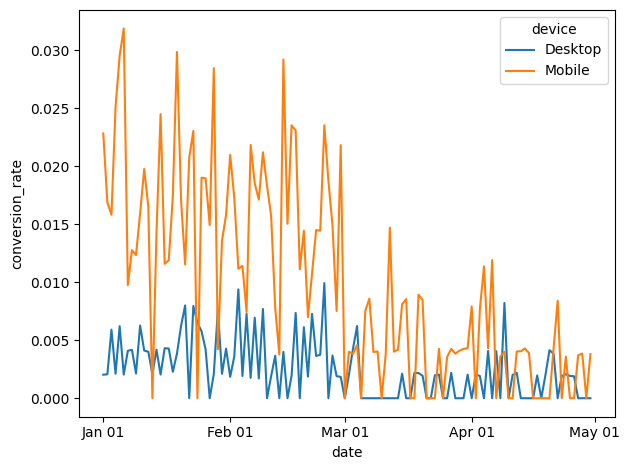

In [32]:
g = sns.lineplot(x="date", hue="device", y="conversion_rate", data=cr_ts)
g.xaxis.set_major_locator(mdates.MonthLocator())
g.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

It actually looks like both desktop and mobile dropped at some point around the beginning of March! Let’s break down the funnel into its page-by-page steps to see if those drops are related to a given page.

In [33]:
#funnel as a time series
funnel = data.groupby(['date', 'device']).apply(
                    lambda x: pd.Series({
                            'to_search' : x['page_search'].mean()/x['page_home'].mean(),
                            'to_payment': x['page_payment'].mean()/x['page_search'].mean(),
                            'to_confirmation': x['page_confirmation'].mean()/x['page_payment'].mean()
  })).reset_index()

In [34]:
funnel.head()

,date,device,to_search,to_payment,to_confirmation
0,2015-01-01,Desktop,0.519270,0.183594,0.021277
1,2015-01-01,Mobile,0.821918,0.161111,0.172414
2,2015-01-02,Desktop,0.539256,0.168582,0.022727
3,2015-01-02,Mobile,0.784810,0.215054,0.100000
4,2015-01-03,Desktop,0.437870,0.099099,0.136364


In [35]:
#Make the dataset long for the plot
funnel = pd.melt(funnel,id_vars=['date', 'device'])

In [36]:
funnel.head()

,date,device,variable,value
0,2015-01-01,Desktop,to_search,0.519270
1,2015-01-01,Mobile,to_search,0.821918
2,2015-01-02,Desktop,to_search,0.539256
3,2015-01-02,Mobile,to_search,0.784810
4,2015-01-03,Desktop,to_search,0.437870


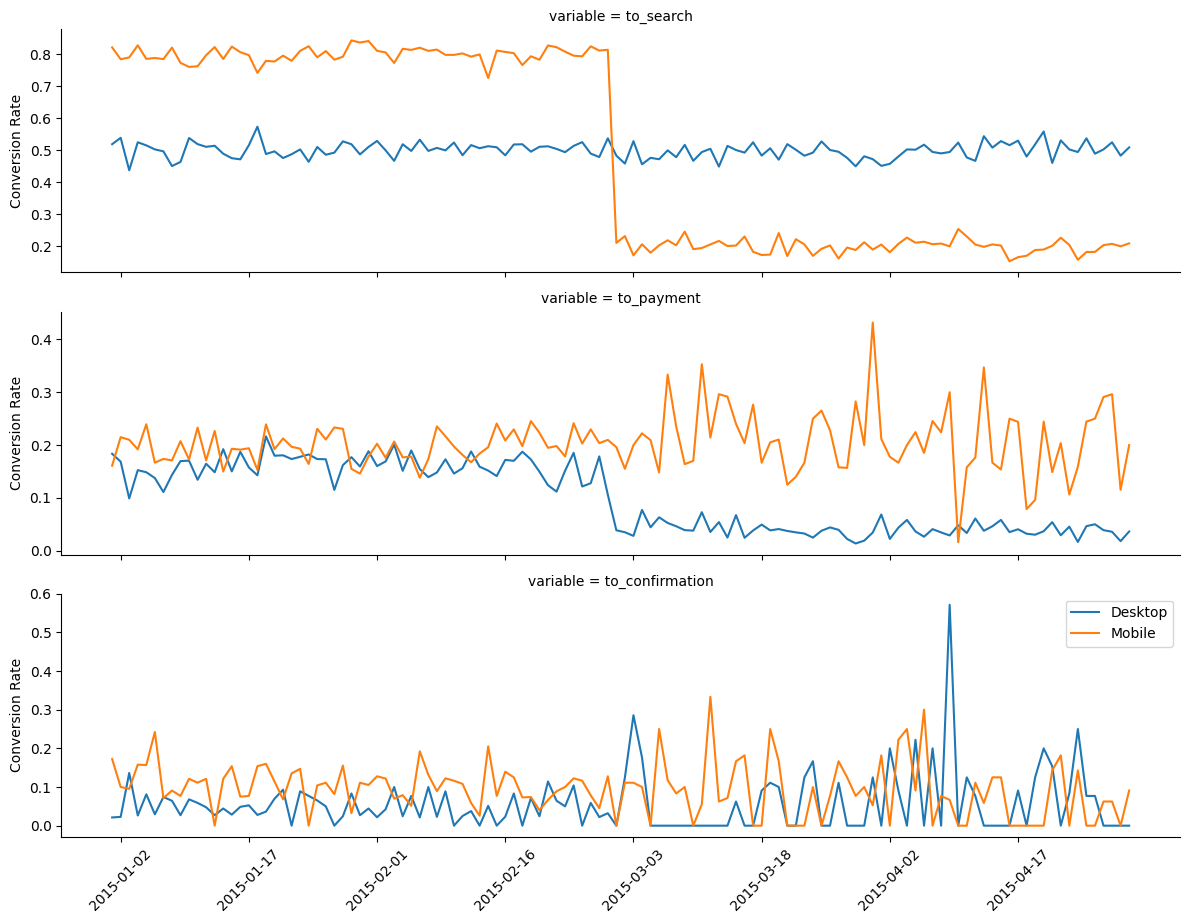

In [37]:
#Plot it
g = sns.FacetGrid(funnel, hue="device", row="variable", aspect=4, sharey=False)
g.map(sns.lineplot, "date", "value")
g.set_axis_labels("", "Conversion Rate")
g.set(xticks=funnel.date[2::30].unique())
plt.xticks(rotation=45)
plt.legend(loc='upper right')

It looks like both Desktop and Mobile dropped on March, 1st. However, this happened on different pages. Mobile had a huge increase in number of bouncers (i.e. people who didn’t go past the home page). Desktop saw a huge increase in the percentage of people leaving the site after landing on the search page.

Q: Some insights on what the product team should focus on in order to improve conversion rate
The classical way to do this would be to build a machine learning model to predict conversion rate, where the features would be time-based variables, device, and sex.

However, in a situation as simple as this, and with so few variables, we might not need a model. We already looked at seasonality and device in depth. The only thing left here is the variable sex. We can just look at it independently to see if it is at all informative.

In [38]:
data.groupby('sex')['page_confirmation'].agg({'mean', 'count'})

,mean,count
sex,,
Female,0.005347,45075
Male,0.004655,45325


We almost have the same number of Male and Female users. And conversion rate appears pretty similar too. Let’s check if that small difference in conversion rate is statistically significant:


In [39]:
from scipy import stats
test = stats.ttest_ind(data.loc[data['sex'] == 'Female']['page_confirmation'], data.loc[data['sex'] != 'Female']['page_confirmation'], equal_var=False)


In [40]:
print(test.statistic)

1.473291657657286


In [41]:
print(test.pvalue)

0.14067591026227633


It is not significant. So, overall, sex doesn’t affect conversion rate in a statistically significant way. Finally, let’s see if sex interacts with device.


In [42]:
data.groupby(['device', 'sex'])['page_confirmation'].agg({'mean', 'count'})

mean  count
device  sex                    
Desktop Female  0.002467  29997
        Male    0.002516  30203
Mobile  Female  0.011076  15078
        Male    0.008927  15122

It looks like the entire difference in conversion rate between males and females comes from mobile. Hard to say more without having more variables. It could very well be noise, or a proxy for some other variables. In any case, this is something that might lead to further analysis, although it is certainly not a top priority given everything else we discovered.

# Insights

1 Desktop has way more users than mobile, but much lower conversion rate. Having less mobile visitors is pretty worrisome. Pretty much all healthy tech companies should have more mobile users than desktop. So growing mobile should be a top priority for the company as a whole

2 There are a couple of ways to explain the lower conversion rate on desktop:
Product: desktop has a worse product. So product team should look into the differences between the two to see if UX/UI can be improved on desktop

3 Marketing: the two platforms are attracting different kinds of users. So they just act as a proxy for user distribution. For instance, mobile didn’t get popular and only has power users, who obviously convert at a much higher rate. Or desktop is spending a lot on ads and these ads are attracting lower intent users.
If we had more data about the users, we could find out if user distribution is the same across the devices (so it is most likely a product problem) or not (-> marketing problem). The marketing explanation has the advantage of explaining also the strangely lower absolute count for mobile users

4 All key metrics for both devices have actually gone down a lot in the last few months. All drops though appear to happen on specific days and one specific pages. This kind of behavior is often the sign of a bug (more likely) or bad product changes (which at the end of the day are basically bugs too, just product bugs instead of engineering bugs). Usual analysis steps to find out why a metric suddenly dropped should be done here.

5 It is hard to say without more information about the site, but the funnel numbers across the board don’t look particularly good. For instance, even before the bug, only at most 20% of users go from the search page to the payment page. These are clearly users with some sort of intent. It could be interesting to look into the characteristics of the search queries to see if people are constantly looking for something they cannot find. Essentially, trying to understand lack of supply compared to user demand.